In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_path = load_path('train', 'n', 'neg', data = 'sm_diff')
# redspot_path = load_path('train', 'h', 'redspot', data = 'sm_diff')
# angio_path = load_path('train', 'h', 'angio', data = 'sm_diff')
# active_path = load_path('train', 'h', 'active', data = 'sm_diff')
ero_path = load_path('train', 'd', 'ero', data = 'sm_diff')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm_diff')
str_path = load_path('train', 'd', 'str', data = 'sm_diff')

print("negative:",neg_path.shape)
# print("red spot:",redspot_path.shape)
# print("angioectasia:",angio_path.shape)
# print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (8352,)
erosion: (3496,)
ulcer: (3552,)
stricture: (664,)


In [3]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
# redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
# angio_train_path, angio_valid_path = train_valid_split(angio_path)
# active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
# print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
# print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
# print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (7099,) (1253,)
erosion: (2972,) (524,)
ulcer: (3019,) (533,)
stricture: (564,) (100,)


# Model

In [4]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [5]:
class CE_cnn:
    def __init__(self, k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output):
        self.k1_ch = k1_ch
        self.k2_ch = k2_ch
        self.k3_ch = k3_ch
        self.k4_ch = k4_ch
        self.k5_ch = k5_ch
        self.k6_ch = k6_ch
        self.k7_ch = k7_ch
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
    def conv_block(self, x, k_channel, maxp_name = 'maxp'):
        conv1 = tf.layers.conv2d(inputs = x, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs = conv1, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                       pool_size = [2, 2], 
                                       strides = 2,
                                       name = maxp_name)
        return maxp

    def fc2_layers(self, x, n_hidden1, n_hidden2, n_output, score_name = 'score'):
        maxp_re = tf.layers.flatten(x)
        hidden1 = tf.layers.dense(inputs = maxp_re, 
                                  units = n_hidden1,
                                  activation = tf.nn.relu)
        hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
        hidden2 = tf.layers.dense(inputs = hidden1, 
                                  units = n_hidden2,
                                  activation = tf.nn.relu)
        hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
        score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
        return score

    def inf(self, x):
        conv1 = self.conv_block(x, self.k1_ch, 'maxp1')
        conv2 = self.conv_block(conv1, self.k2_ch, 'maxp2')
        conv3 = self.conv_block(conv2, self.k3_ch, 'maxp3')
        conv4 = self.conv_block(conv3, self.k4_ch, 'maxp4')
        conv5 = self.conv_block(conv4, self.k5_ch, 'maxp5')
        conv6 = self.conv_block(conv5, self.k6_ch, 'maxp6')
        conv7 = self.conv_block(conv6, self.k7_ch, 'maxp7')

        score = self.fc2_layers(conv7, self.n_hidden1, self.n_hidden2, self.n_output, 'score')

        return score

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
LR = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0114 01:44:30.618586 140243679762176 deprecation.py:323] From <ipython-input-5-249d499180cf>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0114 01:44:30.624755 140243679762176 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0114 01:44:30.836873 140243679762176 deprecation.py:323] From <ipython-input-5-249d499180cf>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0114 01:44:31.133544 140243679762176 deprecation.py:323] F

# Training

In [7]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

a_train_path = shuffle(d_train_path, None)
a_valid_path = shuffle(d_valid_path, None)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 74.00 %    || 78.00 %    || 0.57505983 || 0.54965299
--------------------------------------------------------------


W0114 01:48:03.780735 140243679762176 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*200] || 79.00 %    || 74.00 %    || 0.48130476 || 0.54433417
--------------------------------------------------------------
[*300] || 79.00 %    || 77.00 %    || 0.43935958 || 0.48523873
--------------------------------------------------------------
[*400] || 83.00 %    || 74.00 %    || 0.41839162 || 0.44459546
--------------------------------------------------------------
[*500] || 86.00 %    || 81.00 %    || 0.36423320 || 0.33913195
--------------------------------------------------------------
[*600] || 89.00 %    || 87.00 %    || 0.23760086 || 0.33674297
--------------------------------------------------------------
[*700] || 82.00 %    || 84.00 %    || 0.29589841 || 0.41470516
--------------------------------------------------------------
[*800] || 90.00 %    || 92.00 %    || 0.26792467 || 0.25517637
--------------------------------------------------------------
[*900] || 90.00 %    || 88.00 %    || 0.22997731 || 0.27867222
-------------------------------------------------------

[6700] || 99.00 %    || 97.00 %    || 0.02560052 || 0.09826634
--------------------------------------------------------------
[6800] || 98.00 %    || 91.00 %    || 0.05035471 || 0.38418022
--------------------------------------------------------------
[6900] || 99.00 %    || 96.00 %    || 0.01812147 || 0.13160680
--------------------------------------------------------------
[7000] || 99.00 %    || 89.00 %    || 0.02238348 || 0.20950785
--------------------------------------------------------------
[7100] || 100.00 %    || 96.00 %    || 0.01240730 || 0.23623823
--------------------------------------------------------------
[7200] || 100.00 %    || 93.00 %    || 0.00932829 || 0.28058755
--------------------------------------------------------------
[7300] || 100.00 %    || 97.00 %    || 0.00208547 || 0.08264778
--------------------------------------------------------------
[7400] || 100.00 %    || 94.00 %    || 0.00587228 || 0.20922191
---------------------------------------------------

[13200] || 100.00 %    || 94.00 %    || 0.00606371 || 0.54524183
--------------------------------------------------------------
[13300] || 100.00 %    || 91.00 %    || 0.00094606 || 0.55416489
--------------------------------------------------------------
[13400] || 96.00 %    || 93.00 %    || 0.06257921 || 0.45513344
--------------------------------------------------------------
[13500] || 100.00 %    || 92.00 %    || 0.00268844 || 0.31770226
--------------------------------------------------------------
[13600] || 100.00 %    || 93.00 %    || 0.00003597 || 0.55516517
--------------------------------------------------------------
[13700] || 100.00 %    || 92.00 %    || 0.00392449 || 0.49451607
--------------------------------------------------------------
[13800] || 100.00 %    || 94.00 %    || 0.00059652 || 0.21518387
--------------------------------------------------------------
[13900] || 99.00 %    || 92.00 %    || 0.00812185 || 0.43530169
-----------------------------------------

[19700] || 100.00 %    || 96.00 %    || 0.00017154 || 0.06103719
--------------------------------------------------------------
[19800] || 100.00 %    || 92.00 %    || 0.00037293 || 0.36342239
--------------------------------------------------------------
[19900] || 100.00 %    || 90.00 %    || 0.00034780 || 0.27070925
--------------------------------------------------------------
[20000] || 100.00 %    || 97.00 %    || 0.00004915 || 0.10961083
--------------------------------------------------------------
[20100] || 100.00 %    || 90.00 %    || 0.00006654 || 0.64909822
--------------------------------------------------------------
[20200] || 98.00 %    || 96.00 %    || 0.04192843 || 0.20819192
--------------------------------------------------------------
[20300] || 100.00 %    || 92.00 %    || 0.00016216 || 0.48847690
--------------------------------------------------------------
[20400] || 100.00 %    || 89.00 %    || 0.00346652 || 0.60264367
----------------------------------------

[26200] || 100.00 %    || 94.00 %    || 0.00001009 || 0.28821969
--------------------------------------------------------------
[26300] || 100.00 %    || 91.00 %    || 0.00068922 || 0.73140788
--------------------------------------------------------------
[26400] || 100.00 %    || 96.00 %    || 0.00034981 || 0.20022064
--------------------------------------------------------------
[26500] || 100.00 %    || 87.00 %    || 0.00304373 || 0.64109921
--------------------------------------------------------------
[26600] || 99.00 %    || 95.00 %    || 0.01440062 || 0.17100811
--------------------------------------------------------------
[26700] || 100.00 %    || 95.00 %    || 0.00030400 || 0.15118465
--------------------------------------------------------------
[26800] || 100.00 %    || 92.00 %    || 0.00022143 || 0.28462407
--------------------------------------------------------------
[26900] || 100.00 %    || 86.00 %    || 0.00483631 || 0.51378429
----------------------------------------

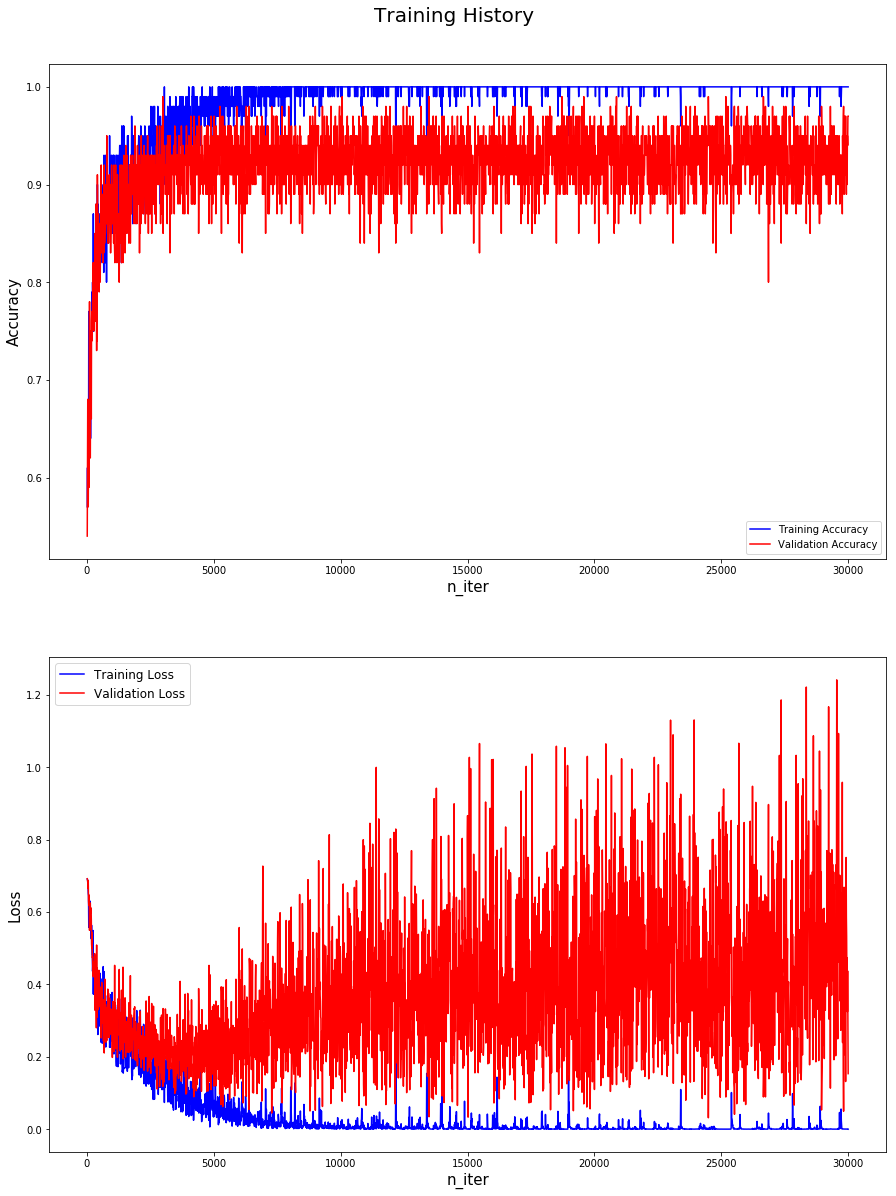

In [8]:
n_iter = 0
t_batch = 50
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
mean_loss_valid = []

hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: 1e-4})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)
        
        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)
        if len(loss_valid) > 10:
            mean_loss_valid.append(np.mean(loss_valid[-10:]))
            if mean_loss_valid[-1] == np.min(mean_loss_valid):
                now = datetime.datetime.now()
                nowDatetime = now.strftime('%y%m%d%H%M')
                model_name = 'ND_sm_diff_{0}_{1}_val_mean_loss_{2:.6f}'.format(nowDatetime, n_iter, mean_loss_valid[-1])
                saver.save(sess, './model/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()